<h1>Setup</h1>


In [47]:
!pip install gymnasium[box2d] stable_baselines3 shimmy
!pip install numpy

In [48]:
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np
import os as os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys

<H1>Load Expert

In [49]:
# Environment ID
ENV_ID = "LunarLander-v3"

# Path to the pre-trained expert model
MODEL_PATH = "expert_ppo_lunarlander_v3.zip"

# Create the environment
env = gym.make(ENV_ID, render_mode="rgb_array")

# Load the Expert Model
try:
    os.path.exists(MODEL_PATH)
    expert_model = PPO.load(MODEL_PATH, env=env)
    print(f"Expert model '{MODEL_PATH}' loaded successfully!")
except:
    print(f"Error: The file '{MODEL_PATH}' was not found. ")
    sys.exit(1)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Expert model 'expert_ppo_lunarlander_v3.zip' loaded successfully!


<h1>Data Collection Function

In [50]:

def generate_expert_data(model, env, n_episodes=100, save_path="expert_data.npz"):

    print(f"Starting data collection for {n_episodes} episodes...")

    # Lists to store observations (states) and actions
    states = []
    actions = []
    total_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Record the current State
            states.append(obs)

            # Get the Action from the Expert
            # deterministic=True ensures the expert plays its best move every time
            action, _ = model.predict(obs, deterministic=True)

            # Record the Action taken
            actions.append(action)

            # Step the environment
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_rewards.append(episode_reward)

    # Convert lists to Numpy arrays for efficient storage
    states = np.array(states)
    actions = np.array(actions)

    # Save to a compressed .npz file
    np.savez_compressed(save_path, states=states, actions=actions)

    avg_reward = np.mean(total_rewards)
    print(f"Data saved to: {save_path}")
    print(f"Stats: Collected {len(states)} samples (steps).")
    print(f"Average Expert Reward: {avg_reward:.2f}")

    #return states, actions

<h1>Generate Datasets

In [51]:
# 1. Small Dataset (Few-Shot Learning Challenge)
# Purpose: To test if the model can learn from very limited data.
generate_expert_data(expert_model, env, n_episodes=10, save_path="expert_data_small.npz")

print("-" * 50)

# 2. Medium Dataset
# Purpose: Intermediate checkpoint for performance analysis.
generate_expert_data(expert_model, env, n_episodes=50, save_path="expert_data_medium.npz")

print("-" * 50)

# 3. Large Dataset (Full Training)
# Purpose: To train the best possible Imitation Learning model.
generate_expert_data(expert_model, env, n_episodes=100, save_path="expert_data_large.npz")
print("-" * 50)

# 4 More Datasets to Check the "Saturation Point"
generate_expert_data(expert_model, env, n_episodes=3, save_path="expert_data_3ep.npz")
print("-" * 50)
generate_expert_data(expert_model, env, n_episodes=5, save_path="expert_data_5ep.npz")
print("-" * 50)
generate_expert_data(expert_model, env, n_episodes=250, save_path="expert_data_250ep.npz")
print("-" * 50)
generate_expert_data(expert_model, env, n_episodes=500, save_path="expert_data_500ep.npz")



print("-" * 50)

Starting data collection for 10 episodes...
Data saved to: expert_data_small.npz
Stats: Collected 3209 samples (steps).
Average Expert Reward: 253.45
--------------------------------------------------
Starting data collection for 50 episodes...
Data saved to: expert_data_medium.npz
Stats: Collected 13350 samples (steps).
Average Expert Reward: 266.65
--------------------------------------------------
Starting data collection for 100 episodes...
Data saved to: expert_data_large.npz
Stats: Collected 26860 samples (steps).
Average Expert Reward: 264.99
--------------------------------------------------
Starting data collection for 3 episodes...
Data saved to: expert_data_3ep.npz
Stats: Collected 726 samples (steps).
Average Expert Reward: 285.37
--------------------------------------------------
Starting data collection for 5 episodes...
Data saved to: expert_data_5ep.npz
Stats: Collected 1262 samples (steps).
Average Expert Reward: 266.45
-------------------------------------------------

<h1>Verification

In [71]:

#Load the large dataset to inspect shapes
data = np.load("expert_data_large.npz")
#data = np.load("expert_data_small.npz")

print("Verifying 'expert_data_large.npz':")
#print("Verifying 'expert_data_small.npz':")
print(f"States shape: {data['states'].shape}")   # (Total_Steps, 8)
print(f"Actions shape: {data['actions'].shape}") # (Total_Steps,)

# Show a sample entry
print("\nSample State [0]:", data['states'][0])
print("Sample Action [0]:", data['actions'][0])

Verifying 'expert_data_large.npz':
States shape: (26860, 8)
Actions shape: (26860,)

Sample State [0]: [ 2.2192001e-04  1.4073749e+00  2.2470905e-02 -1.5757461e-01
 -2.5045194e-04 -5.0899829e-03  0.0000000e+00  0.0000000e+00]
Sample Action [0]: 0


<h1>Load the dataset</h1>

In [72]:
data = np.load("expert_data_large.npz")
#data = np.load("expert_data_small.npz")

X = data['states']
y = data['actions']

print(f"Original Data Shapes:")
print(f"States (X): {X.shape}")
print(f"Actions (y): {y.shape}")

# Example of raw action data
print(f"Sample raw action: {y[0]}")

Original Data Shapes:
States (X): (26860, 8)
Actions (y): (26860,)
Sample raw action: 0


<h1>Preprocessing</h1>

In [73]:
# Convert actions to One-Hot Encoding (Categorical)
# Example: 2 -> [0, 0, 1, 0]
num_classes = 4  #4 possible actions
y_categorical = keras.utils.to_categorical(y, num_classes)

# Split into Training and Validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print("\nData after processing:")
print(f"Training Data: X={X_train.shape}, y={y_train.shape}")
print(f"Validation Data: X={X_val.shape}, y={y_val.shape}")


Data after processing:
Training Data: X=(21488, 8), y=(21488, 4)
Validation Data: X=(5372, 8), y=(5372, 4)


<h1>Build the Model</h1>

In [ ]:
model = keras.Sequential([

    layers.Input(shape=(8,)),

    layers.Dense(64, activation='relu'),

    layers.Dense(64, activation='relu'),

    layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Standard loss for multi-class classification
    optimizer='adam',                 # Best general-purpose optimizer
    metrics=['accuracy']              # Track accuracy during training
)

model.summary() #How the model looks

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

<h1>Train the Model</h1>

Epoch 1/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6010 - loss: 1.0527 - val_accuracy: 0.6700 - val_loss: 0.7409
Epoch 2/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6881 - loss: 0.6847 - val_accuracy: 0.7299 - val_loss: 0.5306
Epoch 3/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8080 - loss: 0.4796 - val_accuracy: 0.8703 - val_loss: 0.3909
Epoch 4/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8755 - loss: 0.3688 - val_accuracy: 0.8889 - val_loss: 0.3276
Epoch 5/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.3133 - val_accuracy: 0.9120 - val_loss: 0.2784
Epoch 6/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9065 - loss: 0.2750 - val_accuracy: 0.8987 - val_loss: 0.2594
Epoch 7/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9161 - loss: 0.2472 - val_accuracy: 0.9254 - val_loss: 0.2289
Epoch 8/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9169 - loss: 0.2296 - val_accuracy: 0.

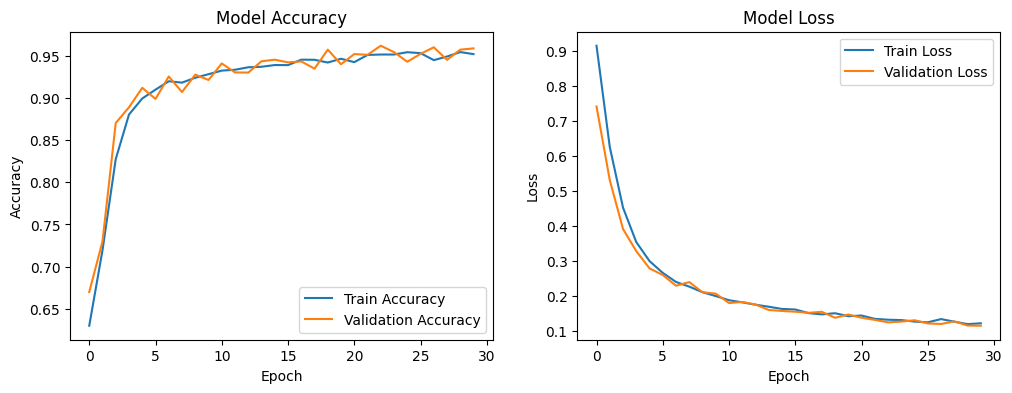

In [75]:
history = model.fit(
    X_train, y_train,
    epochs=30,              # How many times to go over the entire dataset
    batch_size=64,          # Update weights every 64 samples
    validation_data=(X_val, y_val),
    verbose=1
)

# Plotting Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [76]:
# Save the trained Keras model
model.save("imitation_model.keras")
print("Model saved successfully as 'imitation_model.keras'")

Model saved successfully as 'imitation_model.keras'




---



---



---



<h1>Train All Models (7)

In [58]:
datasets_to_train = {
    "model_3": "expert_data_3ep.npz",
    "model_5": "expert_data_5ep.npz",
    "model_10": "expert_data_small.npz",
    "model_50": "expert_data_medium.npz",
    "model_100": "expert_data_large.npz",
    "model_250": "expert_data_250ep.npz",
    "model_500": "expert_data_500ep.npz",
}
all_histories = {}

# Loop through each dataset to train a separate model
for model_name, data_path in datasets_to_train.items():
    print(f"\nProcessing: {model_name} (using {data_path})")

    try:
        # 1. Load and Prepare Data
        data = np.load(data_path)

        # Handle naming inconsistency
        if 'states' in data:
            X = data['states']
        else:
            X = data['observations']
        y = data['actions']

        # One-Hot Encoding
        num_classes = 4
        y = keras.utils.to_categorical(y, num_classes)

        # 2. Define Model Architecture
        model = keras.Sequential([
            layers.Input(shape=(8,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(4, activation='softmax')
        ])

        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

        # 3. Train the Model
        print(f"Training {model_name}...")
        # FIX: Assign the result to 'history' variable
        history = model.fit(
            X, y,
            epochs=30,
            batch_size=64,
            verbose=0,
            validation_split=0.2,
            shuffle=True)

        all_histories[model_name] = history

        # 4. Save the Model
        filename = f"{model_name}.keras"
        model.save(filename)
        print(f"Saved: {filename}")

    except Exception as e:
        print(f"Error processing {model_name}: {e}")

print("-" * 80)
print("\nAll models trained successfully!")



Processing: model_3 (using expert_data_3ep.npz)
Training model_3...
Saved: model_3.keras

Processing: model_5 (using expert_data_5ep.npz)
Training model_5...
Saved: model_5.keras

Processing: model_10 (using expert_data_small.npz)
Training model_10...
Saved: model_10.keras

Processing: model_50 (using expert_data_medium.npz)
Training model_50...
Saved: model_50.keras

Processing: model_100 (using expert_data_large.npz)
Training model_100...
Saved: model_100.keras

Processing: model_250 (using expert_data_250ep.npz)
Training model_250...
Saved: model_250.keras

Processing: model_500 (using expert_data_500ep.npz)
Training model_500...
Saved: model_500.keras
--------------------------------------------------------------------------------

All models trained successfully!


Evaluation (Success Rate & Average Reward)

In [59]:
env = gym.make("LunarLander-v3")

models_to_test = [
    ("model_3", 3),
    ("model_5", 5),
    ("model_10", 10),
    ("model_50", 50),
    ("model_100", 100),
    ("model_250", 250),
    ("model_500", 500)
]

success_rates = []
average_rewards = []
data_points = []

print("Starting Comprehensive Evaluation...\n")

for name, data_count in models_to_test:
    filename = f"{name}.keras"
    print(f"Testing {name} (Trained on {data_count} episodes)...")

    try:
        model = keras.models.load_model(filename)

        success_count = 0
        total_reward_sum = 0 # To calculate average later
        n_test_episodes = 100

        for ep in range(n_test_episodes):
            state, _ = env.reset()
            done = False
            episode_reward = 0

            while not done:
                state_reshaped = state.reshape(1, -1)
                action_probs = model(state_reshaped, training=False).numpy()
                action = np.argmax(action_probs[0])

                # Handling the 5 return values correctly
                state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                episode_reward += reward

            # Update metrics
            total_reward_sum += episode_reward
            if episode_reward >= 200:
                success_count += 1

        # Calculate statistics for this model
        success_rate = (success_count / n_test_episodes) * 100
        avg_score = total_reward_sum / n_test_episodes

        print(f"   Success Rate: {success_rate}% | Avg Reward: {avg_score:.2f}")

        # Store data
        success_rates.append(success_rate)
        average_rewards.append(avg_score)
        data_points.append(data_count)

    except Exception as e:
        print(f"   Error testing {name}: {e}")
        success_rates.append(0)
        average_rewards.append(0)
        data_points.append(data_count)

env.close()

Starting Comprehensive Evaluation...

Testing model_3 (Trained on 3 episodes)...
   Success Rate: 0.0% | Avg Reward: -182.07
Testing model_5 (Trained on 5 episodes)...
   Success Rate: 75.0% | Avg Reward: 188.89
Testing model_10 (Trained on 10 episodes)...
   Success Rate: 94.0% | Avg Reward: 258.03
Testing model_50 (Trained on 50 episodes)...
   Success Rate: 98.0% | Avg Reward: 266.93
Testing model_100 (Trained on 100 episodes)...
   Success Rate: 96.0% | Avg Reward: 265.63
Testing model_250 (Trained on 250 episodes)...
   Success Rate: 97.0% | Avg Reward: 263.22
Testing model_500 (Trained on 500 episodes)...
   Success Rate: 96.0% | Avg Reward: 265.07


Plotting Success Rates

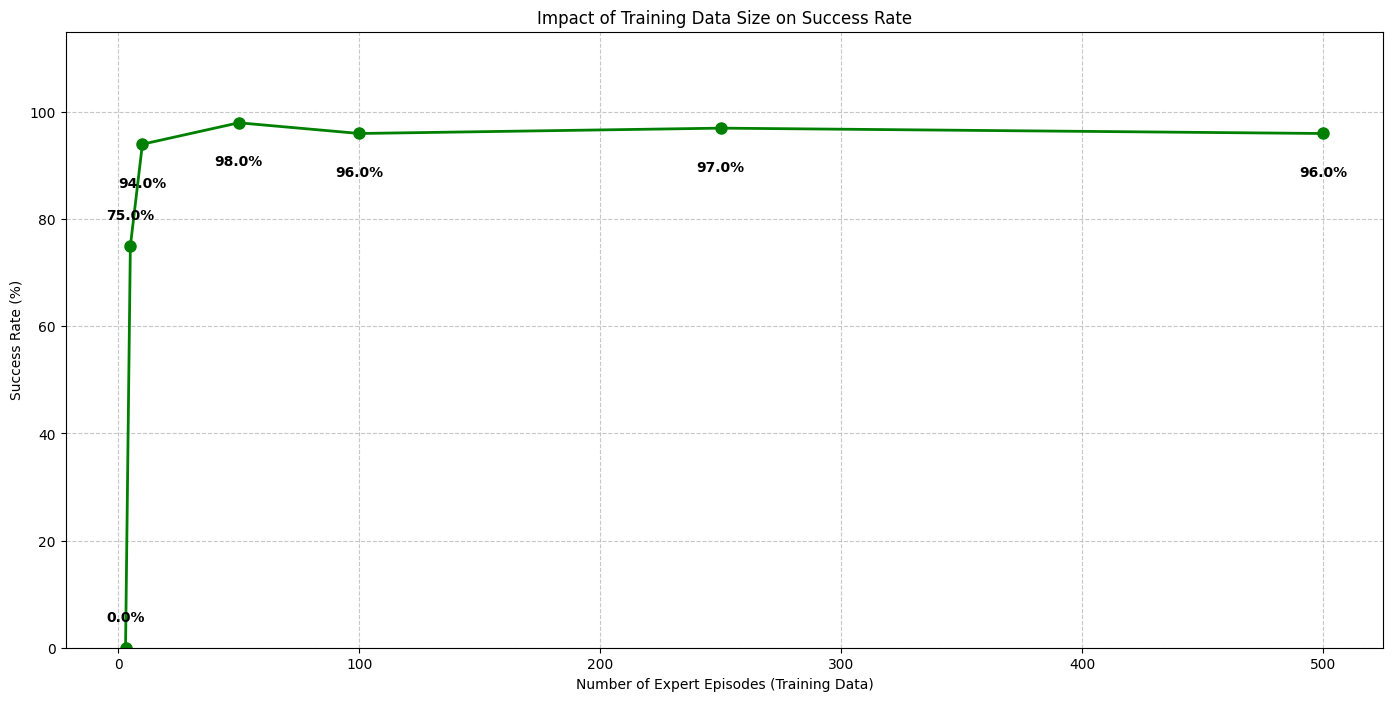

In [60]:
plt.figure(figsize=(17, 8))
plt.plot(data_points, success_rates, marker='o', linestyle='-', color='green', linewidth=2, markersize=8)

plt.title('Impact of Training Data Size on Success Rate')
plt.xlabel('Number of Expert Episodes (Training Data)')
plt.ylabel('Success Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 115)

for x, y in zip(data_points, success_rates):
    vertical_offset = -8 if y > 90 else 5
    plt.text(x, y + vertical_offset, f"{y:.1f}%", ha='center', fontweight='bold')

plt.show()

Plotting Average Reward vs Expert

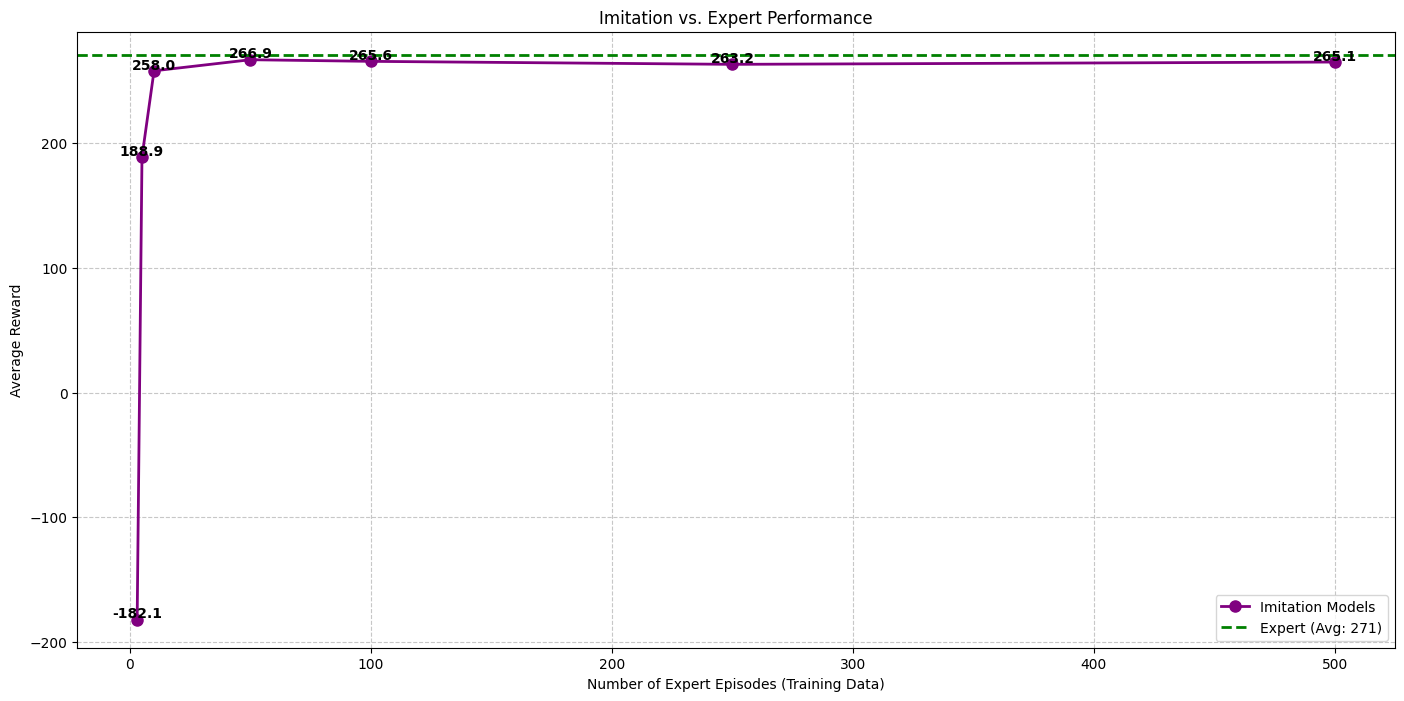

In [61]:
plt.figure(figsize=(17, 8))

plt.plot(data_points, average_rewards, marker='o', linestyle='-', color='purple', linewidth=2, markersize=8, label='Imitation Models')

# Expert Benchmark Line
expert_score = 271
plt.axhline(y=expert_score, color='green', linestyle='--', linewidth=2, label=f'Expert (Avg: {expert_score})')

plt.title('Imitation vs. Expert Performance')
plt.xlabel('Number of Expert Episodes (Training Data)')
plt.ylabel('Average Reward')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

for x, y in zip(data_points, average_rewards):
    plt.text(x, y + 1.5, f"{y:.1f}", ha='center', fontweight='bold')

plt.show()

In [62]:
print(list(all_histories.keys()))

print("-" * 60)
print("Final Validation Accuracy for each model:")
for name, history in all_histories.items():
    final_acc = history.history['val_accuracy'][-1]
    print(f"{name}: {final_acc:.4f}")

['model_3', 'model_5', 'model_10', 'model_50', 'model_100', 'model_250', 'model_500']
------------------------------------------------------------
Final Validation Accuracy for each model:
model_3: 0.7329
model_5: 0.7589
model_10: 0.8972
model_50: 0.9607
model_100: 0.9391
model_250: 0.9297
model_500: 0.9862


Video Recording


In [78]:
import imageio
from IPython.display import Video, display
def record_video(model_filename, output_filename):
    print(f"Loading model from {model_filename}...")
    model = keras.models.load_model(model_filename)

    video_env = gym.make("LunarLander-v3", render_mode="rgb_array")
    obs, _ = video_env.reset()
    done = False

    writer = imageio.get_writer(output_filename, fps=30)
    print(f"Recording flight to {output_filename}... ")

    while not done:
        frame = video_env.render()
        writer.append_data(frame)

        obs_input = np.expand_dims(obs, axis=0)
        action_probs = model(obs_input, training=False).numpy()
        action = np.argmax(action_probs[0])

        obs, _, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated

    writer.close()
    video_env.close()
    print(f"Success! Video saved")

def show_video(filename):
    if not os.path.exists(filename):
        print(f"Error: Video file '{filename}' not found.")
        return
    print(f"Displaying video: {filename}")
    display(Video(filename, embed=True, html_attributes="controls autoplay loop"))


record_video("model_3.keras", "video_model_3.mp4")
show_video("video_model_3.mp4")

record_video("model_5.keras", "video_model_5.mp4")
show_video("video_model_5.mp4")

record_video("model_10.keras", "video_model_10.mp4")
show_video("video_model_10.mp4")

record_video("model_50.keras", "video_model_50.mp4")
show_video("video_model_50.mp4")
'''
record_video("model_100.keras", "video_model_100.mp4")
show_video("video_model_100.mp4")

record_video("model_250.keras", "video_model_250.mp4")
show_video("video_model_250.mp4")

record_video("model_500.keras", "video_model_500.mp4")
show_video("video_model_500.mp4")
'''

Loading model from model_3.keras...
Recording flight to video_model_3.mp4... 
Success! Video saved
Displaying video: video_model_3.mp4


Loading model from model_5.keras...
Recording flight to video_model_5.mp4... 
Success! Video saved
Displaying video: video_model_5.mp4


Loading model from model_10.keras...
Recording flight to video_model_10.mp4... 
Success! Video saved
Displaying video: video_model_10.mp4


Loading model from model_50.keras...
Recording flight to video_model_50.mp4... 
Success! Video saved
Displaying video: video_model_50.mp4


'\nrecord_video("model_100.keras", "video_model_100.mp4")\nshow_video("video_model_100.mp4")\n\nrecord_video("model_250.keras", "video_model_250.mp4")\nshow_video("video_model_250.mp4")\n\nrecord_video("model_500.keras", "video_model_500.mp4")\nshow_video("video_model_500.mp4")\n'